
# Question 1

## 导入数据
1. 导入这两列数据，并进行简单的数据预处理。
2. 用matplotlib.pyplot画出每行两列值组成的点的分布的二维平面图。通过观察，初步上粗滤地确定聚类的簇数目。

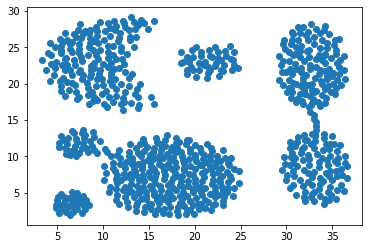

In [8]:
# -*- coding: UTF-8 -*-
# @Author  : Wang Huanchen <11810419@mail.sustech.edu.cn>
# @Time    : 2021/4/30 15:35

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Question 1

# Loads the data and data preprocessing.
HW3_1 = pd.read_csv("HW3_1_data.csv")
# HW3_1.head()
X = HW3_1.iloc[:, :].values.reshape(-1, 2)

plt.scatter(X[:, 0], X[:, 1])

## 使用K-means聚类
由于K-means对于非凸数据集比较难收敛，因此在通过对样本分布图的粗滤观察，来选择聚类的簇的数量范围，以及max_iter的范围，对于max_iter，较小的值可以防止迭代次数过多而更加难以收敛。
1. 首先想到对于Kmeans，可以采用手肘法来对聚类的簇数进行确定，通过绘制不同簇数的惯性图，来找到拐点区域，确定n_clusters。
2. 通过 1. 可以确定 n_clusters可以在 [2,4] 区间选取， 但明显可以肉眼看出簇应该在 [6,7] 这个区间， 原来手肘法并不适用与非凸数据集，因此为了尽可能的优化kmeans在非凸数据的表现，只好减小max_iter， 来让聚类更符合时间， 虽然最后的评估结果不一定是最好，但比较接近真实情况。

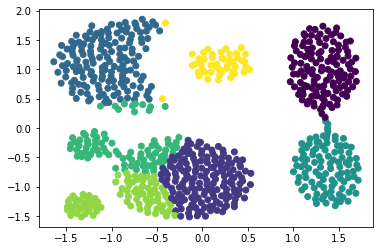

1292.4964861576238


In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Standardize X.
sc = StandardScaler()
X = sc.fit_transform(X)

# Use the law of the elbow.
n_clusters = 9
score = []
for i in range(1, n_clusters):
    kmeans = KMeans(n_clusters=i, random_state=50)
    kmeans.fit(X)
    score.append(kmeans.inertia_)
# plt.plot(score, 'bx-')

# Use the K-means to clusting.
kmeans = KMeans(n_clusters=7, max_iter=20, random_state=80).fit(X)
y_pred = kmeans.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

# get the score.
print(metrics.calinski_harabasz_score(X, y_pred))

## 使用DBSCAN聚类
对距离阈值eps 以及 最小样本数min_samples在sklean.cluster.DBSCAN中的调参：
1. 通过用plot展现最终结果，直接观察不同颜色的簇，来粗滤评判聚类效果：类别过少，则需要减小eps，增大min_samples，类别划分过多，增大eps,减小min_samples。 
2. 通过上面确定的eps和min_sampls的大致范围，设定区间，然后通过循环，选出该区间中聚类效果最好的两值，并用他们来进行DBSCAN聚类。

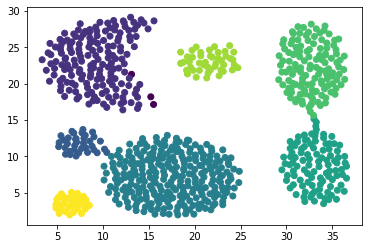

1052.3234235637947


In [10]:
from sklearn.cluster import DBSCAN

X = HW3_1.iloc[:, :].values.reshape(-1, 2)

# Find the optimal eps and min_samples for DBSCAN.
best_eps = 0
best_min_simples = 0
max = -10
for eps in np.arange(1, 2, 0.05):
    for min_samples in range(1, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        y_pred = dbscan.fit_predict(X)
        if max < metrics.calinski_harabasz_score(X, y_pred):
            max = metrics.calinski_harabasz_score(X, y_pred)
            best_eps = eps
            best_min_simples = min_samples

# Use DBSCAN to clusting.
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_simples).fit(X)
y_pred = dbscan.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred) 
plt.show()

# get the score.
print(metrics.calinski_harabasz_score(X, y_pred))

# Question 2
## 数据预处理部分：
1. 首先通过使用 **HW3_2.isnull().sum()** 发现数据中，在MINIMUM_PAYMENTS和CREDIT_LIMIT列有nan值，对此，需要进行补全，根据该两列的实际意义，都可以使用该两列的均值mean替代，因此使用 **HW3_2.fillna(HW3_2.mean(),inplace=True)**。
2. 通过对每列数据的用途和文档中的解释以及每列数据的范围，可以大致分为三类：比列频率类，交易数类，份额类这三大类。对这三大类本别进行区别化的处理。并根据每个列的不同范围，为他们划分出不同label出来，并添加到HW3_2这个DataFrame中。并把原来的数值部分删掉，只保留新加的每个属性的所给标签值。方便后面对X的标准化以及对后续每个簇的具体含义进行理解。
3. 将新加的16个列与TENURE列，共17个列作为X，并对X做标准化，在数据预处理层面优化X。

In [4]:
# Loads the data and data preprocessing
HW3_2 = pd.read_csv('HW3_2_data.csv')
# HW3_2.isnull().sum()

HW3_2.fillna(HW3_2.mean(), inplace=True)

# HW3_2.sample(20)

# Give each columns' values a new label for the clusting.
RATIO = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
         'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']

for ratio in RATIO:
    Label = ratio + '_LABEL_RANGE'
    HW3_2[Label] = 0
    HW3_2.loc[((HW3_2[ratio] > 0) & (HW3_2[ratio] <= 0.1)), Label] = 1
    HW3_2.loc[((HW3_2[ratio] > 0.1) & (HW3_2[ratio] <= 0.2)), Label] = 2
    HW3_2.loc[((HW3_2[ratio] > 0.2) & (HW3_2[ratio] <= 0.3)), Label] = 3
    HW3_2.loc[((HW3_2[ratio] > 0.3) & (HW3_2[ratio] <= 0.4)), Label] = 4
    HW3_2.loc[((HW3_2[ratio] > 0.4) & (HW3_2[ratio] <= 0.5)), Label] = 5
    HW3_2.loc[((HW3_2[ratio] > 0.5) & (HW3_2[ratio] <= 0.6)), Label] = 6
    HW3_2.loc[((HW3_2[ratio] > 0.6) & (HW3_2[ratio] <= 0.7)), Label] = 7
    HW3_2.loc[((HW3_2[ratio] > 0.7) & (HW3_2[ratio] <= 0.8)), Label] = 8
    HW3_2.loc[((HW3_2[ratio] > 0.8) & (HW3_2[ratio] <= 0.9)), Label] = 9
    HW3_2.loc[((HW3_2[ratio] > 0.9) & (HW3_2[ratio] <= 1.0)), Label] = 10

TRX = ['PURCHASES_TRX', 'CASH_ADVANCE_TRX']

for trx in TRX:
    Label = trx + '_LABEL_RANGE'
    HW3_2[Label] = 0
    HW3_2.loc[((HW3_2[trx] > 0) & (HW3_2[trx] <= 10)), Label] = 1
    HW3_2.loc[((HW3_2[trx] > 10) & (HW3_2[trx] <= 20)), Label] = 2
    HW3_2.loc[((HW3_2[trx] > 20) & (HW3_2[trx] <= 30)), Label] = 3
    HW3_2.loc[((HW3_2[trx] > 30) & (HW3_2[trx] <= 40)), Label] = 4
    HW3_2.loc[((HW3_2[trx] > 40) & (HW3_2[trx] <= 50)), Label] = 5
    HW3_2.loc[((HW3_2[trx] > 50) & (HW3_2[trx] <= 60)), Label] = 6
    HW3_2.loc[((HW3_2[trx] > 60) & (HW3_2[trx] <= 70)), Label] = 7
    HW3_2.loc[((HW3_2[trx] > 70) & (HW3_2[trx] <= 80)), Label] = 8
    HW3_2.loc[((HW3_2[trx] > 80) & (HW3_2[trx] <= 90)), Label] = 9
    HW3_2.loc[((HW3_2[trx] > 90) & (HW3_2[trx] <= 100)), Label] = 10
    HW3_2.loc[(HW3_2[trx] > 100), Label] = 11

VALUE = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
         'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

for value in VALUE:
    Label = value + '_LABEL_RANGE'
    HW3_2[Label] = 0
    HW3_2.loc[((HW3_2[value] > 0) & (HW3_2[value] <= 500)), Label] = 1
    HW3_2.loc[((HW3_2[value] > 500) & (HW3_2[value] <= 1000)), Label] = 2
    HW3_2.loc[((HW3_2[value] > 1000) & (HW3_2[value] <= 3000)), Label] = 3
    HW3_2.loc[((HW3_2[value] > 3000) & (HW3_2[value] <= 5000)), Label] = 4
    HW3_2.loc[((HW3_2[value] > 5000) & (HW3_2[value] <= 10000)), Label] = 5
    HW3_2.loc[((HW3_2[value] > 10000)), Label] = 6

# Standardize X.
X = HW3_2.iloc[:, 17:].values.reshape(-1, 17)
sc = StandardScaler()
X = sc.fit_transform(X)

## 具体的聚类过程：
1. 选用Kmeans对X进行聚类， 由于是高维平面，没有比较好的办法，直观的看出来大致可以聚类的簇的区间，因此先设定n_clusers最大为20，并用Kmeans常用的手肘法，用matplotlib.pyplot绘图，来看惯性这一参数的明显拐点在哪里，然后用它作为最终聚类的n_clusters值。
2. 通过图，可以确定n_clusters在 [4,6] 这个区间，再通过评判这三点的calinski_harabasz_score来最终确定选择那个合适
3. 完成聚类。

1982.904612069612


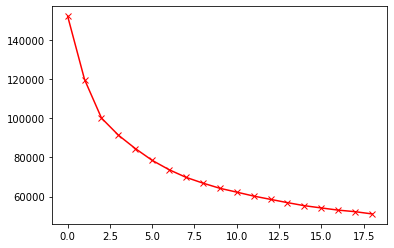

In [5]:
# Use the law of the elbow.
n_clusters = 20
score = []
for i in range(1, n_clusters):
    kmeans = KMeans(n_clusters=i, random_state=50)
    kmeans.fit(X)
    score.append(kmeans.inertia_)

plt.plot(score, 'rx-')

max = -1
n_clusters = 4
for i in range(4, 7):
    kmeans = KMeans(n_clusters=i, random_state=50)
    kmeans.fit(X)
    y_pred = kmeans.fit_predict(X)
    if max < metrics.calinski_harabasz_score(X, y_pred):
        max = metrics.calinski_harabasz_score(X, y_pred)
        n_clusters = i

# print(n_clusters)

# Use K-means to clusting.
kmeans = KMeans(n_clusters=n_clusters, random_state=50)
kmeans.fit(X)
y_pred = kmeans.fit_predict(X)
print(metrics.calinski_harabasz_score(X, y_pred))